##### """adapted""" from [classification.ipynb](https://www.tensorflow.org/tutorials/images/classification)
####Dataset from [kaggle](https://www.kaggle.com/mostafaabla/garbage-classification)

## Import TensorFlow and other libraries

In [1]:
#!pip install tf-nightly==2.5.0.dev20210302
!pip install tensorflow_addons
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(tf.__version__)

2.4.1


If you already have the model weights, you can import it here and skip to [predictions on new data](https://colab.research.google.com/drive/1l02Zrc0Yf5BdJBYoYeFTrupkCNDubrrP#scrollTo=dtv5VbaVb-3W).

## Get the data
save the dataset as garbo.zip to the main folder of your Google Drive ...

The actual dataset looks like this  
<sub>this is what it should look like *inside* `garbo.zip`</sub>

```
garbage_classification/
  battery/
  biological/
  brown-glass/
  cardboard/
  clothes/
  green-glass/
  metal/
  paper/
  plastic/
  shoes/
  trash/
  white-glass/
```

In [2]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -d /content /content/gdrive/MyDrive/dataset-resized.zip
data_dir = pathlib.Path('/content/dataset-resized')
#uncomment following lines if you're using your own dataset.
##!unzip /content/dataset-resized.zip
##data_dir = pathlib.Path('/content/dataset-resized')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/MyDrive/dataset-resized.zip
replace /content/dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


This should show 15k images:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


Sanity Check:

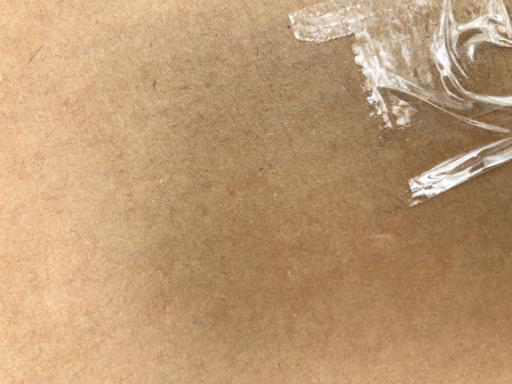

In [4]:
cardboard = list(data_dir.glob('cardboard/*'))
PIL.Image.open(str(cardboard[0]))

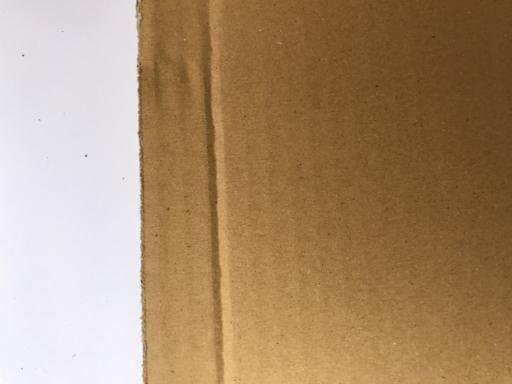

In [5]:
PIL.Image.open(str(cardboard[1]))

Define some parameters for the data input:

In [34]:
batch_size = 32
img_height = 224
img_width = 224

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [37]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names,num_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] 6


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [40]:
base = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')

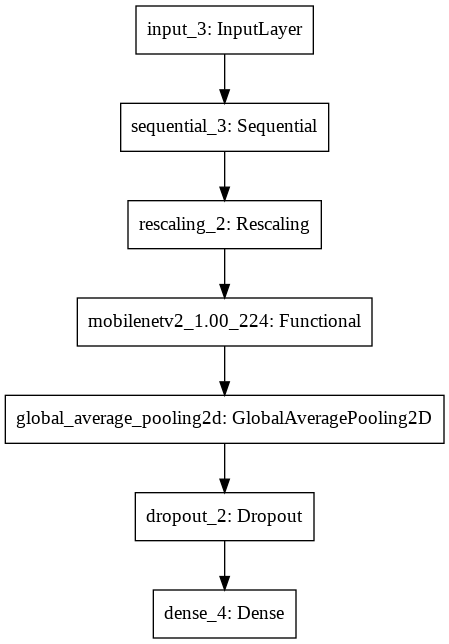

In [41]:
start = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(start)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
end = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(start, end)
keras.utils.plot_model(model, "model.png")

####Load model weights here (if you want)

In [ ]:
from google.colab import files
model.load_weights(next(iter(files.upload())))

StopIteration: ignored

## Compile and train the model

In [58]:
base.trainable = False

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7686  

In [61]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
64/64 [==============================] - 7s 62ms/step - loss: 0.4956 - accuracy: 0.8173 - val_loss: 0.5664 - val_accuracy: 0.7921
Epoch 2/10
64/64 [==============================] - 3s 51ms/step - loss: 0.4656 - accuracy: 0.8309 - val_loss: 0.5638 - val_accuracy: 0.7901
Epoch 3/10
64/64 [==============================] - 3s 51ms/step - loss: 0.5040 - accuracy: 0.8037 - val_loss: 0.5644 - val_accuracy: 0.7861
Epoch 4/10
64/64 [==============================] - 3s 51ms/step - loss: 0.4641 - accuracy: 0.8339 - val_loss: 0.5580 - val_accuracy: 0.7921
Epoch 5/10
64/64 [==============================] - 3s 51ms/step - loss: 0.4743 - accuracy: 0.8165 - val_loss: 0.5525 - val_accuracy: 0.7901
Epoch 6/10
64/64 [==============================] - 3s 51ms/step - loss: 0.4624 - accuracy: 0.8367 - val_loss: 0.5456 - val_accuracy: 0.7921
Epoch 7/10
64/64 [==============================] - 3s 51ms/step - loss: 0.4474 - accuracy: 0.8372 - val_loss: 0.5492 - val_accuracy: 0.7881
Epoch 8/10
64

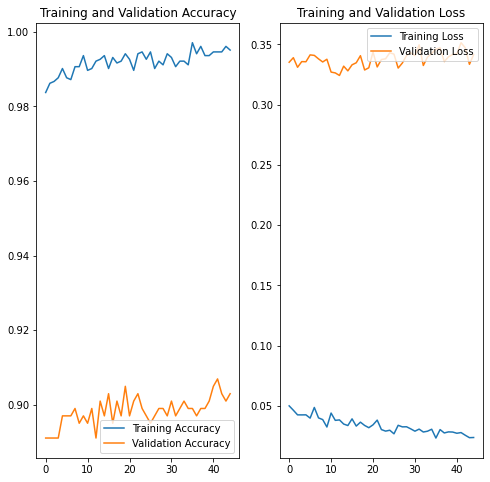

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Fine tuning

In [64]:
base.trainable = True
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.000001),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7686  

In [67]:
epochs = 45
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/45
64/64 [==============================] - 16s 244ms/step - loss: 0.0500 - accuracy: 0.9837 - val_loss: 0.3351 - val_accuracy: 0.8911
Epoch 2/45
64/64 [==============================] - 16s 247ms/step - loss: 0.0463 - accuracy: 0.9862 - val_loss: 0.3389 - val_accuracy: 0.8911
Epoch 3/45
64/64 [==============================] - 16s 249ms/step - loss: 0.0425 - accuracy: 0.9866 - val_loss: 0.3309 - val_accuracy: 0.8911
Epoch 4/45
64/64 [==============================] - 16s 245ms/step - loss: 0.0425 - accuracy: 0.9876 - val_loss: 0.3357 - val_accuracy: 0.8911
Epoch 5/45
64/64 [==============================] - 16s 243ms/step - loss: 0.0425 - accuracy: 0.9901 - val_loss: 0.3355 - val_accuracy: 0.8970
Epoch 6/45
64/64 [==============================] - 16s 242ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.3412 - val_accuracy: 0.8970
Epoch 7/45
64/64 [==============================] - 16s 244ms/step - loss: 0.0486 - accuracy: 0.9871 - val_loss: 0.3408 - val_accuracy: 0.8970

## Predict on new data

In [71]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


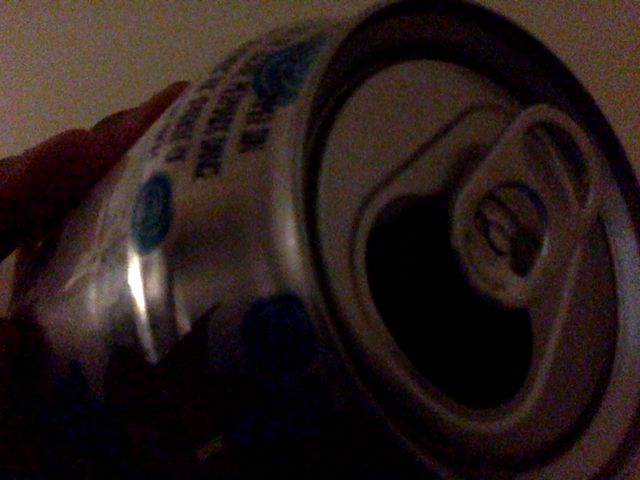

In [72]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [73]:

photo_path = "/content/photo.jpg"
img = keras.preprocessing.image.load_img(
    photo_path
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.preprocessing.image.smart_resize(
    img_array,(img_height,img_width), interpolation='bilinear'
)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to metal with a 99.98 percent confidence.


##Export Model &#8595;

In [68]:
from google.colab import files
model.save_weights('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>